### Libraries

In [254]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy import ndimage

import shapely.geometry as geom
import pandas as pd
import geopandas as gpd

import math
import time
import pickle
from collections import namedtuple


%matplotlib inline
plt.rcParams["figure.figsize"] = (20,7)

## Load from disk

In [255]:
poses = pickle.load(open("poses.df", 'rb'))
arena_d = pickle.load(open("arena_d.df", 'rb'))
arena_g = pickle.load(open("arena_g.gdf", 'rb'))

# Convert Pandas DataFrame to NumPy array
poses_np = np.array(poses.values)

## Variables

In [256]:
Measurement = namedtuple('Measurement', ['sonar', 'IR_L', 'IR_R'])
Motion = namedtuple('Motion', ['distance', 'angle'])
Pose = namedtuple("Pose", ['x', 'y', 'theta'])

## Copy parameters!!!

In [257]:
# THOSE HAVE TO MATCH EXACTLY PARAM IN MAP

RESOLUTION_POS = round(0.1,1)
RESOLUTION_ROT = round(30,1) 

W = 4.25
H = 3.2
OFFSET = 0.01

## Parameters

In [258]:
SENSORS_VARIANCE = {
    'sonar': 0.1,
    'IR_L' : 0.4,
    'IR_R' : 0.4
}

# Further than SENSORS_CUTOFF_STD standard deviations from the mean, 
# we say the sensor readings are improbable for a given pose
SENSORS_CUTOFF_STD = 0.7

CONFIDENCE_SENSORS = 0.6
CONFIDENCE_ODOMETRY = 0.6

## Playground

### Arena

In [259]:
# mock_position = geom.Point(0.01, 0.81)
# # theta = geom.Point(0, 6)
# # mock_circle = geom.Point(0,0).buffer(6, resolution=30)

# # scan = geom.LineString((mock_position, theta))
# # arena_d.loc[len(arena_d)] = ["scan", scan]

# arena_d.loc[len(arena_d)] = ['test', mock_position]
# arena_g = gpd.GeoDataFrame(arena_d)
# arena_g.plot()


# # cleat the dataframe
# arena_d.drop(arena_d.index[arena_d['type'] == 'test'], inplace=True)
# print(arena_g)

### Probability

In [260]:
# sigma = 0.05
# mean = 0.5

# sigma = 1/sigma

# x = np.linspace(0,1,500) # 100 linearly spaced numbers
# y = sigma*2.5*(1/(sigma*math.sqrt(2*math.pi))*np.exp( -(1/2*sigma**2)*((x - mean))**2))

# a = 0.55
# b = sigma*2.5*(1/(sigma*math.sqrt(2*math.pi))*np.exp( -(1/2*sigma**2)*((a - mean))**2))

# plt.plot(x,y)
# plt.plot(a,b,'co')

## Grid Localization

In [261]:
def _match(sensor, reading, lookup_value):
    """
    Determines if a reading from the sensors matches a value 
    in the lookup table with some probability.
    This is useful to find the exact values of 'x' and 'y' as recorded in the lookup table.
    
    """
    SENSORS_CUTOFF_STD = 0.6 
    if reading == None:
        if math.isnan(lookup_value):
            return True
        else:
            return False
    elif sensor == "sonar":
        SIGMA = SENSORS_VARIANCE['sonar']
    elif sensor == "IR_L":
        SIGMA = SENSORS_VARIANCE['IR_L']
    elif sensor == "IR_R":
        SIGMA = SENSORS_VARIANCE['IR_R']

    sigma = 1/SIGMA
    mean = lookup_value
    x = reading
    y = sigma*2.5*(1/(sigma*math.sqrt(2*math.pi))*np.exp( -(1/2*sigma**2)*((x - mean))**2))
    if y > SENSORS_CUTOFF_STD:
        return True
    return False
    

def _closest(number, divider):
    """
    Returns the closest number to 'number'
    divisible without remainder by 'divider'.
    """
    
    mod = number % divider        # 28
    
    low = number - mod            # 90
    high = number - mod + divider # 120
    if high - number < number - low:
        return high
    else:
        return low
    
def locate_row_in_table(x, y, theta):
    largest_y = poses_np[0][2]
    
    y_block = (360/RESOLUTION_ROT)*(np.ceil(W/RESOLUTION_POS))*(largest_y-y)/RESOLUTION_POS
    x_block = (360/RESOLUTION_ROT)*(x-OFFSET)/RESOLUTION_POS
    theta_block = theta/RESOLUTION_ROT
    return int(round(y_block + x_block + theta_block))
    

def localize(poses_np, motion, measurement):
    """
    poses_np    :: a lookup table of possible poses and sensor readings. Columns: open, x, y, theta, sonar, IR_L, IR_R
    measurement :: a tuple of readings from (sonar, IR_L, IR_R).
    
    """
    
    def move_belief():
        """
        Finds posterior probability, given
            distance traveled in a straight line ('x' and 'y' chnge), OR 
            rotation on the spot.
        Posterior poses_np = [prior] X [probability after motion model]
    
        """
        prob_sum = 0
        
        for i in range(len(poses_np)): # iterate rows
            if poses_np[i][0] == 1: # open space, i.e. not coordinates of an obstacle
                theta = poses_np[i][3]
                
                # determine most likely pose where we were before the movement
                delta_x = math.sin((theta + motion.angle) % 360) * motion.distance
                delta_y = math.cos((theta + motion.angle) % 360) * motion.distance
                
                prev_x = _closest(poses_np[i][1] - delta_x, RESOLUTION_POS) + OFFSET
                prev_y = _closest(poses_np[i][2] - delta_y, RESOLUTION_POS) + OFFSET
                prev_theta = _closest((theta - motion.angle) % 360, RESOLUTION_ROT)
                
                # unless previous positions is outside the boundaries of the arena
                if prev_x > 0 and prev_y > 0: 
                    row_idx = locate_row_in_table(prev_x, prev_y, prev_theta)

                # look up the probability of the previous pose
                prev_prob = poses_np[row_idx][7]
                
                # update the probability of the current pose accordingly
                poses_np[i][7] = CONFIDENCE_ODOMETRY * poses_np[i][7] + (1-CONFIDENCE_ODOMETRY) * prev_prob
                
                # update running tally
                prob_sum += poses_np[i][7]
        
        # normalize--> total probability theory
        for i in range(len(poses_np)):
            print(prob_sum)
            poses_np[i][7] = poses_np[i][7] / prob_sum
        
    def sense_belief():
        """
        Finds posterior = [prior] X [probability after measurement]
        
        """

        prob_sum = 0
        
        for i in range(len(poses_np)): # iterate rows
            if poses_np[i][0] == 1: # of open space, i.e. not coordinates of an obstacle
                match_all = False
                if _match('sonar',  measurement.sonar,  poses_np[i][4]):
                    if _match('IR_L',  measurement.IR_L,  poses_np[i][5]):
                        if _match('IR_R',  measurement.IR_R,  poses_np[i][6]):
                            match_all = True
                
                poses_np[i][7] = (poses_np[i][7] * (match_all * CONFIDENCE_SENSORS + (1-match_all) * (1.0-CONFIDENCE_SENSORS)))
                prob_sum += poses_np[i][7]
        
        # normalize--> total probability theory
        for i in range(len(poses_np)):
            poses_np[i][7] = poses_np[i][7] / prob_sum
    
    sense_belief()
    move_belief()
    return poses_np

## Heatmap

In [262]:
def heatmap(poses_np):
    """
    The heatmap relies on the following sorting of the array:
    'y' descending (primary sort)
    'x' ascending (secondary sort)
    'theta' ascending (tertiary sort)
    
    """
    
    plt.rcParams["figure.figsize"] = (10,5)
    heatmap = []
    y = poses_np[0][2]
    row = []
                
    # iterate through lookup table
    for i in range(len(poses_np)): 
        # True while we're moving horizontally to the right – x increases, y stays constant
        if y == poses_np[i][2]:
            if poses_np[i][3] == 0:  # if theta == 0
                row.append(poses_np[i][7]) # append probability
            else:
            # theta is some rotation, we're at same square still
                row[-1] += poses_np[i][7] # saturate probability here 
        # y changes – we're one row lower
        else:
            heatmap.append(row)
            row = []
            y = poses_np[i][2]
            row.append(poses_np[i][7])

    # Make plot with vertical (default) colorbar
    fig, ax = plt.subplots()

    cax = ax.imshow(heatmap, interpolation='nearest', cmap=plt.cm.coolwarm)
    ax.set_title('Probabalistic location')

    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
    cbar.ax.set_yticklabels(['< -1', '0', '> 1'])  # vertically oriented colorbar
    
    plt.show()

# Run

In [263]:
def refresh(poses_np):
    """ 
    Takes all rows where 0-indexed column 1 one,
    and change 7-indexed column to the prior probability.
    
    """
    prob = 1.0 / len(poses_np[:,0])
    poses_np[poses_np[:, 0] == 1, 7] = prob
    return poses_np

def run(poses_np, motions, measurements):
    for i in range(len(measurements)):
        poses_np = localize(poses_np, motions[i], measurements[i]) 
        heatmap(poses_np)
    return poses_np

In [264]:
measurements = [Measurement(0.2, 0.2, 0.2),
                Measurement(0.4, 0.2, 0.3),
#                 Measurement(0.5, 0.2, None),
#                 Measurement(0.6, 0.012310000, None),
#                 Measurement(0.5, 0.012310000, None),
#                 Measurement(0.4, 0.012310000, None),
#                 Measurement(0.3, 0.012310000, None),
#                 Measurement(0.2, 0.012310000, None),
#                 Measurement(None, None, None),
#                 Measurement(None, None, None),
#                 Measurement(None, None, None),
#                 Measurement(None, None, None),
#                 Measurement(None, None, None),
#                 Measurement(None, None, None),
#                 Measurement(None, None, None),
#                 Measurement(None, None, None),
#                 Measurement(None, None, None),
#                 Measurement(0.2, 0.012310000, None),
#                 Measurement(0.2, 0.012310000, None),
#                 Measurement(0.2, 0.012310000, None),
#                 Measurement(0.2, 0.012310000, None),
#                 Measurement(0.2, 0.012310000, None),
#                 Measurement(0.2, 0.012310000, None),
#                 Measurement(0.2, 0.012310000, None),
#                 Measurement(0.2, 0.012310000, None),
               ]

motions      = [Motion(0.1, 0),
                Motion(0.1, 0),
               ]

7.2406053146e-05
7.2406053146e-05
0.0
0.0
7.2406053146e-05
7.2406053146e-05
0.0
0.0
0.0
7.2406053146e-05
0.000108609079719
0.0
7.2406053146e-05
7.2406053146e-05
0.0
0.0
7.2406053146e-05
7.2406053146e-05
0.0
0.0
4.34436318876e-05
7.2406053146e-05
0.000108609079719
0.0
7.2406053146e-05
7.2406053146e-05
0.0
0.0
7.2406053146e-05
7.2406053146e-05
0.0
0.0
6.08210846427e-05
7.2406053146e-05
7.2406053146e-05
0.0
7.2406053146e-05
7.2406053146e-05
0.0
0.0
7.2406053146e-05
7.2406053146e-05
0.0
0.0
6.77720657447e-05
7.2406053146e-05
7.2406053146e-05
0.0
7.2406053146e-05
7.2406053146e-05
0.0
0.0
7.2406053146e-05
7.2406053146e-05
0.0
0.0
7.05524581855e-05
7.2406053146e-05
7.2406053146e-05
0.0
7.2406053146e-05
7.2406053146e-05
0.0
0.0
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
0.0
7.16646151618e-05
7.2406053146e-05
7.2406053146e-05
0.0
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
0.0
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.21094779524e-05
7.2406053146e-05
7

0.0
7.2406053146e-05
7.2406053146e-05
0.0
0.0
7.2406053146e-05
7.2406053146e-05
6.77720657447e-05
6.77720657447e-05
7.2406053146e-05
7.2406053146e-05
6.77720657447e-05
6.77720657447e-05
6.77720657447e-05
7.2406053146e-05
0.000108609079719
6.77720657447e-05
7.2406053146e-05
7.2406053146e-05
6.77720657447e-05
6.77720657447e-05
7.2406053146e-05
7.2406053146e-05
6.77720657447e-05
6.77720657447e-05
7.05524581855e-05
7.2406053146e-05
0.000108609079719
0.000101658098617
7.2406053146e-05
7.2406053146e-05
6.77720657447e-05
6.77720657447e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
6.77720657447e-05
7.16646151618e-05
7.2406053146e-05
7.2406053146e-05
7.99362826732e-05
7.2406053146e-05
7.2406053146e-05
6.77720657447e-05
6.77720657447e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
6.77720657447e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.99362826732e-05
7.2406053146e-05
7.2406053146e-05
6.77720657447e-05
6.77720657447e-05
7.2406053146e-05
7.2406053146e-05
7.24060531

7.2406053146e-05
7.16646151618e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2404838374e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.16646151618e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.24055672372e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.16646151618e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.24058587825e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.16646151618e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.24059754006e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.16646151618e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.24060220479e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.240

7.2406053146e-05
7.2406053146e-05
0.0
7.2406053146e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
0.0
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.21094779524e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.16646151618e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.16646151618e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.05524581855e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.21094779524e-05
7.2406053146e-05
7.2406

7.23870723336e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.16646151618e-05
7.23870723336e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.23870723336e-05
7.2406053146e-05
7.2406053146e-05
7.23870723336e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.23984608211e-05
7.23870723336e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.23870723336e-05
7.2406053146e-05
7.2406053146e-05
7.23870723336e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.23870723336e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.23870723336e-05
7.2406053146e-05
7.2406053146e-05
7.23586011151e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.23586011151e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.23586011151e-05
7.2406053146e-05
7.2406053146e-05
7.3065932952e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.22874230686e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.22874230686e-0

7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
6.08210846427e-05
7.2406053146e-05
7.2406053146e-05
6.08210846427e-05
6.08210846427e-05
7.2406053146e-05
7.2406053146e-05
6.08210846427e-05
6.08210846427e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
6.08210846427e-05
7.2406053146e-05
7.2406053146e-05
6.08210846427e-05
6.08210846427e-05
7.2406053146e-05
7.2406053146e-05
6.08210846427e-05
6.08210846427e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
6.08210846427e-05
7.2406053146e-05
7.2406053146e-05
6.08210846427e-05
6.08210846427e-05
7.2406053146e-05
7.2406053146e-05
6.08210846427e-05
6.08210846427e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
6.08210846427e-05
7.2406053146e-05
7.2406053146e-05
6.08210846427e-05
6.08210846427e-05
7.2406053146e-05
7.2406053146e-05
7.23984608211e-05
6.08210846427e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
6.08210846427e-05
7.2406053146e-05
7.2406053146e-05
6.08210846427e-05
6.08210846427e-05
7.2406053146e-05
7.240605

7.2406053146e-05
7.2406053146e-05
7.24055672372e-05
7.05524581855e-05
7.2406053146e-05
7.2406053146e-05
7.24058587825e-05
7.24055672372e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.24055672372e-05
7.2406053146e-05
7.2406053146e-05
7.24055672372e-05
7.05524581855e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.24055672372e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.24055672372e-05
7.2406053146e-05
7.2406053146e-05
7.24055672372e-05
7.05524581855e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.24055672372e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.24055672372e-05
7.2406053146e-05
7.2406053146e-05
7.24055672372e-05
7.05524581855e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.24055672372e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.24055672372e-05
7.2406053146e-05
7.2406053146e-05
7.24055672372e-05
7.16646151618e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.24055672372e-05
7.2406053146e-05
7.240605314

7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.21094779524e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.21094779524e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.24058587825e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.21094779524e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.24055672372e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.21094779524e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.24055672372e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.21094779524e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.2404838374e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.21094779524e-05
7.240605

7.23586011151e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.23586011151e-05
7.24055672372e-05
7.2406053146e-05
7.2406053146e-05
7.23586011151e-05
7.2406053146e-05
7.2406053146e-05
7.23586011151e-05
7.23586011151e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.23586011151e-05
7.24058587825e-05
7.2406053146e-05
7.2406053146e-05
7.23586011151e-05
7.2406053146e-05
7.2406053146e-05
7.24060407068e-05
7.23586011151e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.24060407068e-05
7.24059754006e-05
7.2406053146e-05
7.2406053146e-05
7.24060407068e-05
7.2406053146e-05
7.2406053146e-05
7.24060407068e-05
7.23586011151e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.24060407068e-05
7.24060220479e-05
7.2406053146e-05
7.2406053146e-05
7.24060407068e-05
7.2406053146e-05
7.2406053146e-05
7.24060407068e-05
7.23586011151e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.24060407068e-05
7.24060407068e-05
7.2406053146e-05
7.2406053146e-05
7.24060407068e-05
7.24060

7.2406053146e-05
7.2406053146e-05
7.23984608211e-05
7.2406053146e-05
7.2406053146e-05
7.23984608211e-05
7.23984608211e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.23984608211e-05
7.24055672372e-05
7.2406053146e-05
7.2406053146e-05
7.23984608211e-05
7.2406053146e-05
7.2406053146e-05
7.24060511558e-05
7.23984608211e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.24060511558e-05
7.24058587825e-05
7.2406053146e-05
7.2406053146e-05
7.24060511558e-05
7.2406053146e-05
7.2406053146e-05
7.24060511558e-05
7.23984608211e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.24060511558e-05
7.24059754006e-05
7.2406053146e-05
7.2406053146e-05
7.24060511558e-05
7.2406053146e-05
7.2406053146e-05
7.24060511558e-05
7.23984608211e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.24060511558e-05
7.24060220479e-05
7.2406053146e-05
7.2406053146e-05
7.24060511558e-05
7.2406053146e-05
7.2406053146e-05
7.24060511558e-05
7.23984608211e-05
7.2406053146e-05
7.2406053146e-05
7.240605

7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
0.0
7.2406053146e-05
7.2406053146e-05
0.0
0.0
7.2406053146e-05
7.2406053146e-05
0.0
0.0
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
0.0
7.2406053146e-05
7.2406053146e-05
0.0
0.0
7.2406053146e-05
7.2406053146e-05
0.0
0.0
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
0.0
7.2406053146e-05
7.2406053146e-05
0.0
0.0
7.2406053146e-05
7.2406053146e-05
7.24060528276e-05
0.0
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
0.0
7.2406053146e-05
7.2406053146e-05
7.24055672372e-05
0.0
7.2406053146e-05
7.2406053146e-05
7.24060523499e-05
7.24055672372e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.24055672372e-05
7.2406053146e-05
7.2406053146e-05
7.24055672372e-05
4.34436318876e-05
7.2406053146e-05
7.2406053146e-05
7.24060523499e-05
7.24055672372e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.24055672372e-05
7.2406053146e-05
7.2406053146e-05
7.24055672372e-05
7.05524581855e-05
7.2406053146e-05
7.2406053146e-05
7.2406

7.2406053146e-05
6.77720657447e-05
7.2406053146e-05
7.2406053146e-05
6.77720657447e-05
6.77720657447e-05
7.2406053146e-05
7.2406053146e-05
7.24060530951e-05
6.77720657447e-05
7.24060803569e-05
7.2406053146e-05
7.2406053146e-05
6.77720657447e-05
7.2406053146e-05
7.2406053146e-05
6.77720657447e-05
6.77720657447e-05
7.2406053146e-05
7.2406053146e-05
7.24060530187e-05
6.77720657447e-05
7.24060640304e-05
7.2406053146e-05
7.2406053146e-05
6.77720657447e-05
7.2406053146e-05
7.2406053146e-05
7.24060220479e-05
6.77720657447e-05
7.2406053146e-05
7.2406053146e-05
7.24060530187e-05
7.24060220479e-05
7.24060574998e-05
7.2406053146e-05
7.2406053146e-05
7.24060220479e-05
7.2406053146e-05
7.2406053146e-05
7.24060220479e-05
6.77720657447e-05
7.2406053146e-05
7.2406053146e-05
7.24060528276e-05
7.24060220479e-05
7.24060548875e-05
7.2406053146e-05
7.2406053146e-05
7.24060220479e-05
7.2406053146e-05
7.2406053146e-05
7.24060220479e-05
6.77720657447e-05
7.2406053146e-05
7.2406053146e-05
7.24060531428e-05
7.2

7.2406053146e-05
7.24060511558e-05
7.24060481703e-05
7.2406053146e-05
7.2406053146e-05
7.24060511558e-05
7.2406053146e-05
7.2406053146e-05
7.24060511558e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.24060511558e-05
7.24060511558e-05
7.2406053146e-05
7.2406053146e-05
7.24060511558e-05
7.2406053146e-05
7.2406053146e-05
7.24060511558e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.2406053146e-05
7.24060511558e-05
7.24060523499e-05
7.2406053146e-05
7.2406053146e-05
7.24060511558e-05
7.2406053146e-05
7.2406053146e-05
7.24060511558e-05
7.21094779524e-05
7.2406053146e-05
7.2406053146e-05
7.21094779524e-05
7.24060511558e-05
7.24060528276e-05
7.2406053146e-05
7.2406053146e-05
7.24060511558e-05
7.2406053146e-05
7.2406053146e-05
7.24060511558e-05
7.22874230686e-05
7.2406053146e-05
0.000108609079719
7.16646151618e-05
7.24060511558e-05
7.24060530187e-05
7.2406053146e-05
7.2406053146e-05
7.24060511558e-05
7.2406053146e-05
7.2406053146e-05
7.24060511558e-05
7.23

0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.98041925

0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.98041925

0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.98041925

0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.98041925

0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.98041925

0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.98041925

0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.98041925

0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.98041925

0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.98041925

0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.98041925

0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.98041925

0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.98041925

0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.980419256107
0.98041925

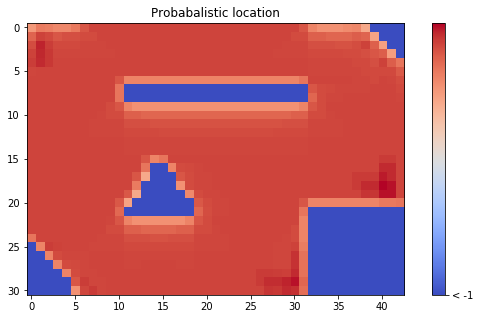

7.36895329098e-05
7.36895329098e-05
0.0
0.0
7.36895329098e-05
7.36895329098e-05
0.0
0.0
0.0
7.36895329098e-05
0.000110534299365
0.0
7.36895329098e-05
7.36895329098e-05
0.0
0.0
7.36895329098e-05
7.36895329098e-05
0.0
0.0
2.65282318475e-05
7.36895329098e-05
9.57963927828e-05
0.0
7.36895329098e-05
7.36895329098e-05
0.0
0.0
7.36895329098e-05
7.36895329098e-05
0.0
0.0
4.77508173256e-05
7.36895329098e-05
7.36895329098e-05
0.0
7.36895329098e-05
7.36895329098e-05
0.0
0.0
7.36895329098e-05
7.36895329098e-05
0.0
0.0
6.04843686124e-05
7.36895329098e-05
7.36895329098e-05
0.0
7.36895329098e-05
7.36895329098e-05
0.0
0.0
7.36895329098e-05
7.36895329098e-05
0.0
0.0
6.72755959653e-05
7.36895329098e-05
7.36895329098e-05
0.0
7.36895329098e-05
7.36895329098e-05
0.0
0.0
7.36895329098e-05
7.36895329098e-05
7.36818060023e-05
0.0
7.06712096418e-05
7.36895329098e-05
7.36895329098e-05
0.0
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
0.0
7.36895329098e-05
7.36895329098e-05
7.36818060023e-05
7.7226630489

4.77508173256e-05
7.36895329098e-05
7.36895329098e-05
0.0
0.0
7.36895329098e-05
7.36895329098e-05
0.0
0.0
7.36895329098e-05
7.36895329098e-05
6.04843686124e-05
6.04843686124e-05
7.36895329098e-05
7.36895329098e-05
6.04843686124e-05
6.04843686124e-05
6.04843686124e-05
7.36895329098e-05
0.000110534299365
6.04843686124e-05
7.36895329098e-05
7.36895329098e-05
6.04843686124e-05
6.04843686124e-05
7.36895329098e-05
7.36895329098e-05
6.04843686124e-05
6.04843686124e-05
6.72755959653e-05
7.36895329098e-05
9.57963927828e-05
9.07265529186e-05
7.36895329098e-05
7.36895329098e-05
6.04843686124e-05
6.04843686124e-05
7.36895329098e-05
7.36895329098e-05
7.36890383877e-05
6.04843686124e-05
7.06712096418e-05
7.36895329098e-05
7.36895329098e-05
0.000101868410295
7.36895329098e-05
7.36895329098e-05
6.04843686124e-05
6.04843686124e-05
7.36895329098e-05
7.36895329098e-05
7.36890383877e-05
6.04843686124e-05
7.23011042065e-05
7.36895329098e-05
7.36895329098e-05
0.000101868410295
7.36895329098e-05
7.3689532909

0.000109591072514
4.42137197459e-05
7.36895329098e-05
7.36894537863e-05
4.42137197459e-05
7.36895329098e-05
7.51043719412e-05
7.36895329098e-05
4.42137197459e-05
4.42137197459e-05
7.36882966046e-05
7.36895329093e-05
0.000110157008606
4.42137197459e-05
7.36895329098e-05
7.36895329093e-05
4.42137197459e-05
7.36895329098e-05
7.51043719412e-05
7.36895329098e-05
4.42137197459e-05
4.42137197459e-05
7.36864421468e-05
7.36895329093e-05
0.000110383383054
4.42137197459e-05
7.36895329098e-05
7.36895329093e-05
4.42137197459e-05
7.36895329098e-05
7.51043719412e-05
7.36895329098e-05
4.42137197459e-05
4.42137197459e-05
7.36818060023e-05
7.36895329093e-05
0.000110473932837
4.42137197459e-05
7.36895329098e-05
7.36895329093e-05
4.42137197459e-05
7.36895329098e-05
7.51043719412e-05
7.36895329098e-05
4.42137197459e-05
4.42137197459e-05
7.36702156409e-05
7.36895329093e-05
0.000110510152753
4.42137197459e-05
7.36895329098e-05
7.36895329093e-05
4.42137197459e-05
7.36895329098e-05
7.51043719412e-05
7.36895329

7.39159071549e-05
7.30617216701e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36887416745e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
4.42137197459e-05
7.39159071549e-05
7.30617216701e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.3689197426e-05
7.36895329098e-05
4.42137197459e-05
7.36895329098e-05
7.36895329098e-05
0.0
7.39159071549e-05
7.30617216701e-05
7.36895329098e-05
0.0
7.36895329098e-05
7.36895329098e-05
7.36893911204e-05
7.36895329098e-05
0.0
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.30617216701e-05
7.36895202501e-05
7.36895329098e-05
7.36895329098e-05
7.23011042065e-05
7.30617216701e-05
0.0
7.36895329098e-05
7.36895329098e-05
7.30617216701e-05
7.36895329098e-05
7.36895329098e-05
7.30617216701e-05
7.36895202501e-05
7.36895329098e-05
7.36895329098e-05
7.23011042065e-05
7.30617216701e-05
2.65282318475e-05
7.36895329098e-05
7.36895329098e-05
7.30617216701e-05
7.36895329098

2.65282318475e-05
2.65282318475e-05
7.36895329098e-05
7.36895329098e-05
2.65282318475e-05
2.65282318475e-05
7.36895328547e-05
7.36895329098e-05
7.36895329098e-05
2.65282318475e-05
7.36895329098e-05
7.36895329098e-05
2.65282318475e-05
2.65282318475e-05
7.36895329098e-05
7.36895329098e-05
2.65282318475e-05
2.65282318475e-05
7.3689532887e-05
7.36895329098e-05
0.000110534299365
2.65282318475e-05
7.36895329098e-05
7.36895329098e-05
2.65282318475e-05
2.65282318475e-05
7.36895329098e-05
7.36895329098e-05
2.65282318475e-05
2.65282318475e-05
7.36895329004e-05
7.36895329098e-05
7.36895329098e-05
2.65282318475e-05
7.36895329098e-05
7.36895329098e-05
2.65282318475e-05
2.65282318475e-05
7.36895329098e-05
7.36895329098e-05
2.65282318475e-05
2.65282318475e-05
7.36895329059e-05
7.36895329098e-05
7.36895329098e-05
2.65282318475e-05
7.36895329098e-05
7.36895329098e-05
2.65282318475e-05
2.65282318475e-05
7.36895329098e-05
7.36895329098e-05
2.65282318475e-05
2.65282318475e-05
7.36895329082e-05
7.368953290

6.04843686124e-05
6.04843686124e-05
7.36895329098e-05
7.36895329098e-05
6.04843686124e-05
6.04843686124e-05
7.36895329092e-05
7.36895329098e-05
7.36895329098e-05
6.04843686124e-05
7.36895329098e-05
7.36895329098e-05
6.04843686124e-05
6.04843686124e-05
7.36895329098e-05
7.36895329098e-05
6.04843686124e-05
6.04843686124e-05
7.36895329095e-05
7.36895329098e-05
7.36895329098e-05
6.04843686124e-05
7.36895329098e-05
7.36895329098e-05
6.04843686124e-05
6.04843686124e-05
7.36895329098e-05
7.36895329098e-05
6.04843686124e-05
6.04843686124e-05
7.36895329097e-05
7.36895329098e-05
7.36895329098e-05
6.04843686124e-05
7.36895329098e-05
7.36895329098e-05
6.04843686124e-05
6.04843686124e-05
7.36895329098e-05
7.36895329098e-05
6.04843686124e-05
6.04843686124e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
6.04843686124e-05
7.36895329098e-05
7.36895329098e-05
6.04843686124e-05
6.04843686124e-05
7.36895329098e-05
7.36895329098e-05
6.04843686124e-05
6.04843686124e-05
7.36895329098e-05
7.36895329

7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36896812664e-05
7.36887416745e-05
7.36895329098e-05
7.36895329098e-05
7.23011042065e-05
7.36895329098e-05
7.36895327771e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.23011042065e-05
7.36887416745e-05
7.36895329098e-05
7.36895329098e-05
7.23011042065e-05
7.23011042065e-05
7.36895328547e-05
7.36895329098e-05
7.36895329098e-05
7.23011042065e-05
7.36895329098e-05
7.36895329098e-05
7.27764901213e-05
7.36887416745e-05
7.36895329098e-05
4.42137197459e-05
7.23011042065e-05
7.23011042065e-05
7.3689532887e-05
7.36895329098e-05
7.36895329098e-05
7.23011042065e-05
7.36895329098e-05
7.36895329098e-05
7.23011042065e-05
7.36887416745e-05
7.36895329098e-05
0.0
7.23011042065e-05
7.23011042065e-05
7.36895329004e-05
7.36895329098e-05
7.36895329098e-05
7.23011042065e-05
0.0
7.36895329098e-05
7.23011042065e-05
7.36887416745e-05
0.0
0.0
7.23011042065e-05
7.23011042065e-05
7.36895329059e-05
0.0
7.3689532

7.36897813577e-05
7.36895329098e-05
7.36895329098e-05
7.36893911204e-05
7.36893911204e-05
7.36895329098e-05
7.36895329098e-05
7.34094325105e-05
7.36893911204e-05
7.36895223769e-05
7.36895329098e-05
7.36895329098e-05
7.36897813577e-05
7.36895329098e-05
7.36895329098e-05
7.36893911204e-05
7.36893911204e-05
7.36895329098e-05
7.36895329098e-05
7.34094325105e-05
7.36893911204e-05
7.36895285022e-05
7.36895329098e-05
7.36895329098e-05
7.36897813577e-05
7.36895329098e-05
7.36895329098e-05
7.36893911204e-05
7.36893911204e-05
7.36895329098e-05
7.36895329098e-05
7.34094325105e-05
7.36893911204e-05
7.3689531069e-05
7.36895329098e-05
7.36895329098e-05
7.36897813577e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36893911204e-05
7.36895329098e-05
7.36895329098e-05
7.34094325105e-05
7.36895335175e-05
7.36895321424e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36895566469e-05
7.36893911204e-05
7.36895329098e-05
7.36895329098e-05
7.340943251

7.36895329098e-05
7.36895329098e-05
7.36354445569e-05
7.36895077928e-05
7.36895329098e-05
7.36895329098e-05
7.36354445569e-05
7.36354445569e-05
4.77508173256e-05
7.36895329098e-05
7.36895329098e-05
7.36354445569e-05
7.36895329098e-05
7.36895329098e-05
7.36354445569e-05
7.36895077928e-05
7.36895329098e-05
7.36895329098e-05
7.36894731557e-05
7.36354445569e-05
6.04843686124e-05
7.36895329098e-05
7.36895329098e-05
7.36354445569e-05
7.36895329098e-05
7.36895329098e-05
7.36354445569e-05
7.36354445569e-05
7.36895329098e-05
7.36895329098e-05
7.36893911204e-05
7.36354445569e-05
6.72755959653e-05
7.36895329098e-05
7.36895329098e-05
7.36354445569e-05
7.36895329098e-05
7.36895329098e-05
7.36354445569e-05
7.36354445569e-05
7.36895329098e-05
7.36895329098e-05
7.36893911204e-05
7.36354445569e-05
7.06712096418e-05
7.36895329098e-05
7.36895329098e-05
7.36354445569e-05
7.36895329098e-05
7.36895329098e-05
7.36354445569e-05
7.36354445569e-05
7.36895329098e-05
7.36895329098e-05
7.3689197426e-05
7.363544455

7.36851811155e-05
7.36895329098e-05
4.42137197459e-05
7.36895329098e-05
7.36851811155e-05
7.36895329098e-05
7.36895329098e-05
4.42137197459e-05
7.36851811155e-05
7.36895329098e-05
0.0
7.36851811155e-05
7.36851811155e-05
7.36895329098e-05
0.0
0.0
7.36851811155e-05
7.36895329098e-05
7.36895329098e-05
0.0
7.36851811155e-05
4.42137197459e-05
7.36895329098e-05
7.36895321424e-05
7.36895321424e-05
4.42137197459e-05
7.36895329098e-05
7.36876735068e-05
7.36895321424e-05
7.36895321424e-05
4.42137197459e-05
7.36895329098e-05
7.36895321424e-05
7.36895329098e-05
7.36895329098e-05
7.36895321424e-05
7.36895321424e-05
7.36895329098e-05
7.36895329098e-05
7.36876735068e-05
7.36895321424e-05
7.36895325904e-05
7.36895329098e-05
7.36895329098e-05
7.36895370251e-05
7.36895329098e-05
7.36895329098e-05
7.36895321424e-05
7.36895321424e-05
7.36895329098e-05
7.36895329098e-05
7.36876735068e-05
7.36895321424e-05
7.36895327771e-05
7.36895329098e-05
7.36895329098e-05
7.36895342308e-05
7.36895329098e-05
7.3689532909

7.36895329098e-05
7.3689197426e-05
7.3689197426e-05
0.000110534299365
7.36895329098e-05
4.77508173256e-05
7.3689197426e-05
7.36895329165e-05
7.36895329098e-05
7.36895329098e-05
7.3689197426e-05
7.36895329098e-05
4.42137197459e-05
7.3689197426e-05
7.3689197426e-05
0.000110534299365
4.42137197459e-05
2.65282318475e-05
7.3689197426e-05
7.36895329126e-05
7.36895329098e-05
4.42137197459e-05
7.3689197426e-05
7.36895329098e-05
0.0
7.3689197426e-05
7.3689197426e-05
0.000110534299365
0.0
0.0
7.3689197426e-05
7.3689532911e-05
7.36895329098e-05
0.0
7.3689197426e-05
0.0
7.36895329098e-05
7.36895328547e-05
7.36895328547e-05
0.0
7.36895329098e-05
7.36893911204e-05
7.36895328547e-05
0.0
0.0
7.36895329098e-05
7.36895330041e-05
4.42137197459e-05
7.36895329098e-05
7.36895328547e-05
7.36895328547e-05
4.42137197459e-05
7.36895329098e-05
7.36893911204e-05
7.36895328547e-05
2.65282318475e-05
4.42137197459e-05
7.36895329098e-05
7.36895330041e-05
7.36895329098e-05
7.36895329098e-05
7.36895328547e-05
7.3689532

0.0
4.42137197459e-05
7.36895329098e-05
7.36895329165e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36895329059e-05
7.36895329098e-05
7.36895329098e-05
7.30617216701e-05
7.36895329098e-05
2.65282318475e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36895329102e-05
7.36895329059e-05
7.36895329098e-05
7.36895329098e-05
7.30617216701e-05
7.36895329098e-05
4.77508173256e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36895329102e-05
7.36895329059e-05
7.36895329098e-05
7.36895329098e-05
7.30617216701e-05
7.36895329098e-05
6.04843686124e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36895329102e-05
7.36895329059e-05
7.36895329098e-05
7.36895329098e-05
7.30617216701e-05
7.36895329098e-05
6.72755959653e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36895329098e-05
7.36895329102e-05
7.36895329059e-05
7.3689

0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.97998952

0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.97998952

0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.97998952

0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.97998952

0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.97998952

0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.97998952

0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.97998952

0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.97998952

0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.97998952

0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.97998952

0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.97998952

0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.97998952

0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.97998952

0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.979989524752
0.97998952

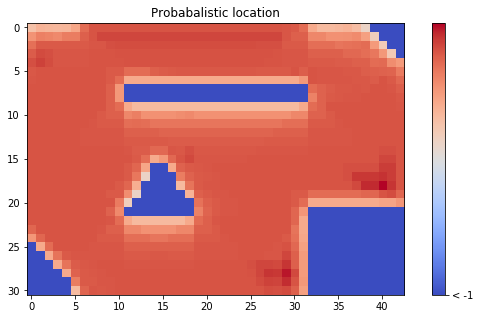

In [265]:
# refresh
poses_np = refresh(poses_np)
# GO!
poses_np = run(poses_np, motions, measurements)

In [211]:
# MUST-DOS
# find sensible sigma
# IR adjust for different variance furhter out
# implement IR
# cut off high readings beyond sensor's reach
# maybe change to Log sum? Underflow problem
# plot on heatmat most likely pose + draw lines which show likely orientations

# SIMULATE

# EXTRAS
# plot orientation on the map somehow
# draw most likely location
# posterior() returning a probability? instead of True / False?

In [193]:
W/RESOLUTION_POS

21.25

In [197]:
x = 4.21
y = 2.81
theta = 0
largest_y = poses_np[0][2]
int(round((360/RESOLUTION_ROT)*(np.ceil(W/RESOLUTION_POS))*(largest_y-y)/RESOLUTION_POS + (360/RESOLUTION_ROT)*(x-OFFSET)/RESOLUTION_POS + theta/RESOLUTION_ROT))

516

In [192]:
i = 516
print(poses_np[i][1])
print(poses_np[i][2])
print(poses_np[i][3])

4.21
2.81
0.0
